<a href="https://colab.research.google.com/github/maxjlake96/weather-forecasting-prophet/blob/main/Weather_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing relevant packages and connecting to the API to retrieve data

In [ ]:
import os
API_KEY = os.getenv("OPENWEATHER_API_KEY")


In [ ]:
import os, requests, pandas as pd

API_KEY = os.getenv("OPENWEATHER_API_KEY")
if not API_KEY:
    raise ValueError("Missing OPENWEATHER_API_KEY. Set it with os.environ[...] before calling the API.")

city = "London"
url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={API_KEY}&units=metric"

r = requests.get(url, timeout=30)
if r.status_code != 200:
    print("OpenWeather error:", r.status_code, r.text[:300])
    raise SystemExit("Stopping because OpenWeather request failed.")

data = r.json()
if "list" not in data:
    print("Unexpected payload:", data)
    raise SystemExit("Stopping because 'list' is missing in the response.")

# Flatten to DataFrame
rows = []
for f in data["list"]:
    rows.append({
        "datetime": f["dt_txt"],
        "temp": f["main"]["temp"],
        "temp_min": f["main"]["temp_min"],
        "temp_max": f["main"]["temp_max"],
        "humidity": f["main"]["humidity"],
        "pressure": f["main"]["pressure"],
        "weather": f["weather"][0]["description"] if f.get("weather") else None,
        "wind_speed": f["wind"].get("speed") if f.get("wind") else None,
        "wind_deg": f["wind"].get("deg") if f.get("wind") else None,
    })
df = pd.DataFrame(rows)
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()


,datetime,temp,temp_min,temp_max,humidity,pressure,weather,wind_speed,wind_deg
0,2025-09-10 09:00:00,16.02,16.02,16.28,79,1004,light rain,6.14,170
1,2025-09-10 12:00:00,16.83,16.83,18.44,75,1004,light rain,5.64,190
2,2025-09-10 15:00:00,17.96,17.96,18.93,67,1002,light rain,5.03,196
3,2025-09-10 18:00:00,16.43,16.43,16.43,75,1000,light rain,4.10,197
4,2025-09-10 21:00:00,16.02,16.02,16.02,89,1000,light rain,4.41,236


Creating a dataframe with from a list of dictionaries, where each dictionary extracts weather data from items in forecast_list

Creating visualizations - one shows temperature over time, the other shows temperature vs humidity by weather condition.
You can see the seasonal trends in temperature, and you can see the negative correlation between humidity and temperature.

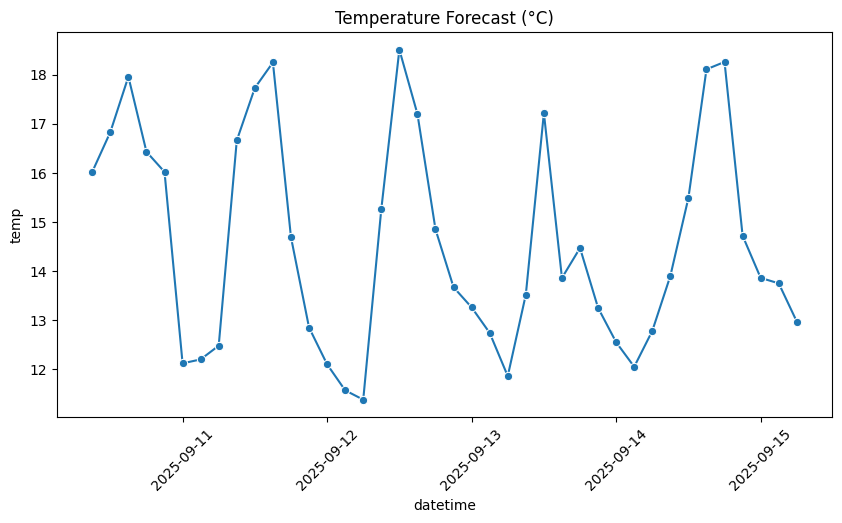

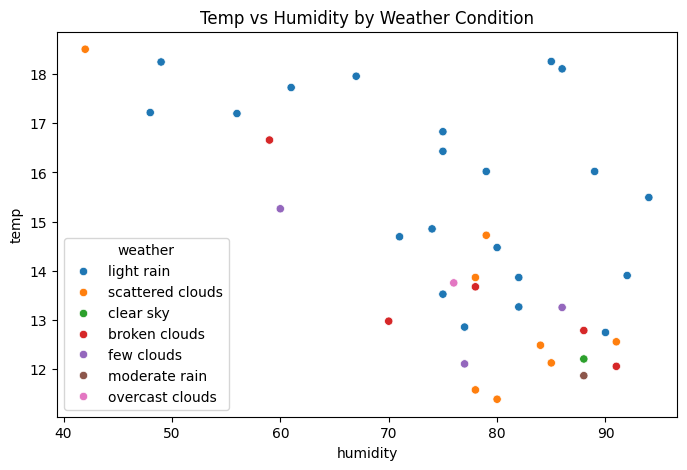

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='datetime', y='temp', marker='o')
plt.title('Temperature Forecast (°C)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='humidity', y='temp', hue='weather')
plt.title('Temp vs Humidity by Weather Condition')
plt.show()


This is showing some descriptive information about the data. This highlights that we are working with a very small dataset. This shows the averages and information about the data including whether the data is negatively or positively skewed.

In [ ]:
# Basic statistics
print(df.describe())

# Data types & nulls
print(df.info())

# Unique values per column
print(df.nunique())


                  datetime       temp   temp_min   temp_max   humidity  \
count                   40  40.000000  40.000000  40.000000  40.000000   
mean   2025-09-12 19:30:00  14.585000  14.585000  14.656000  76.625000   
min    2025-09-10 09:00:00  11.380000  11.380000  11.380000  42.000000   
25%    2025-09-11 14:15:00  12.770000  12.770000  12.770000  73.250000   
50%    2025-09-12 19:30:00  13.880000  13.880000  13.880000  78.500000   
75%    2025-09-14 00:45:00  16.487500  16.487500  16.487500  86.000000   
max    2025-09-15 06:00:00  18.510000  18.510000  18.930000  94.000000   
std                    NaN   2.194522   2.194522   2.296836  12.771538   

          pressure  wind_speed   wind_deg  
count    40.000000   40.000000   40.00000  
mean   1008.125000    5.260500  225.42500  
min    1000.000000    2.950000  170.00000  
25%    1005.000000    4.397500  211.00000  
50%    1008.000000    5.055000  231.00000  
75%    1011.000000    6.140000  238.75000  
max    1015.000000    8.7

This shows the correlation matrix - the relationship between each variable. You can see the strong correlations between temp and humidity, and also wind speed and pressure.

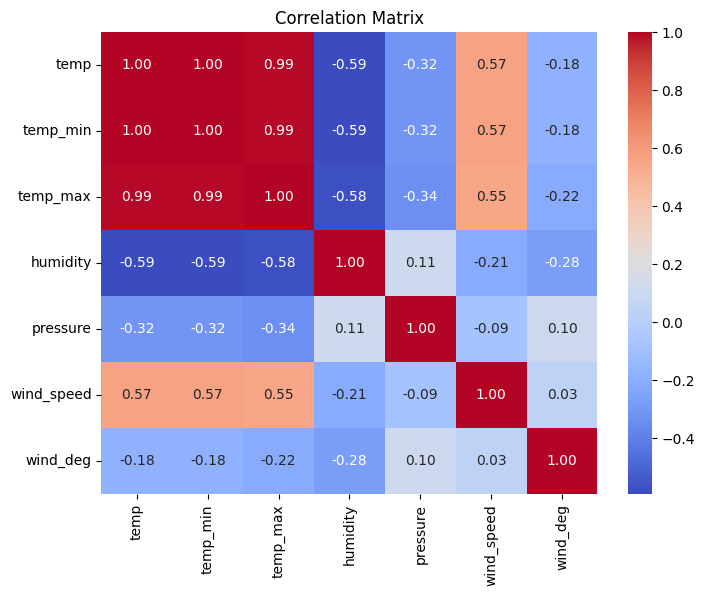

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


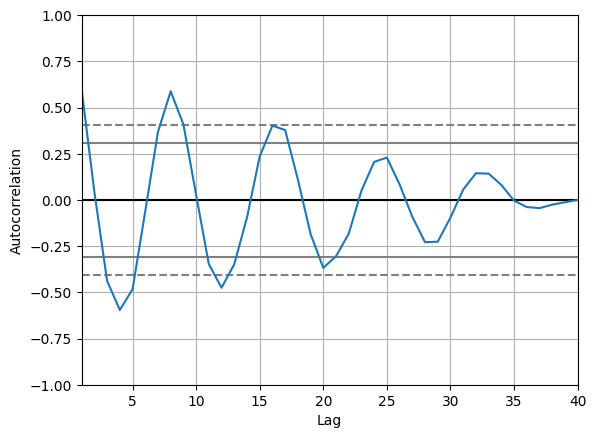

Cross-correlation (Temp vs Humidity): -0.59


In [ ]:
from pandas.plotting import autocorrelation_plot

# Example: autocorrelation of temperature
autocorrelation_plot(df['temp'])
plt.show()

# Cross-correlation between temperature & humidity
cross_corr = df['temp'].corr(df['humidity'])
print(f"Cross-correlation (Temp vs Humidity): {cross_corr:.2f}")


This is looking at the average temperature by weather condition - showing clear sky having the highest average temp in this dataset

weather
light rain          15.698095
overcast clouds     13.750000
broken clouds       13.626000
few clouds          13.536667
scattered clouds    13.398750
clear sky           12.200000
moderate rain       11.860000
Name: temp, dtype: float64


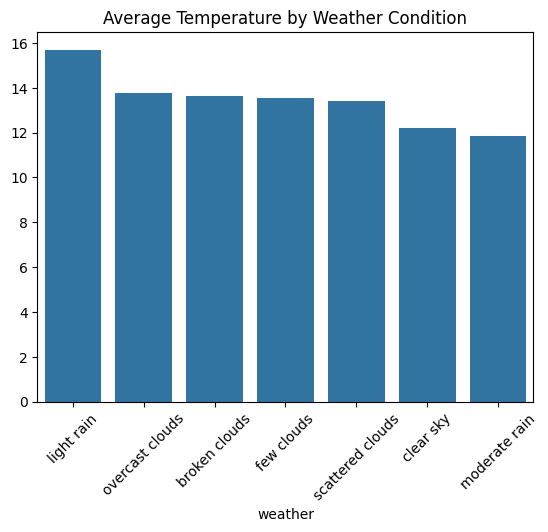

In [ ]:
cond_avg_temp = df.groupby('weather')['temp'].mean().sort_values(ascending=False)
print(cond_avg_temp)

sns.barplot(x=cond_avg_temp.index, y=cond_avg_temp.values)
plt.xticks(rotation=45)
plt.title("Average Temperature by Weather Condition")
plt.show()


In [ ]:
df['day'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour
df['is_weekend'] = df['datetime'].dt.weekday >= 5


Using Prophet for time series forecasting:
1. Prepare data with columns 'ds' (datetime) and 'y' (value to forecast).
2. Fit Prophet model on historical data.
3. Create a future dataframe (e.g. next 48 hours, hourly).
4. Predict future values (yhat) with confidence intervals.
5. Plot results: actual data, forecast line, and uncertainty bands.


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxh9wo3o8/s3574fj5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxh9wo3o8/lwcrf5oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99936', 'data', 'file=/tmp/tmpxh9wo3o8/s3574fj5.json', 'init=/tmp/tmpxh9wo3o8/lwcrf5oz.json', 'output', 'file=/tmp/tmpxh9wo3o8/prophet_modelg3z_yulj/prophet_model-20250910082701.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
08:27:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packag

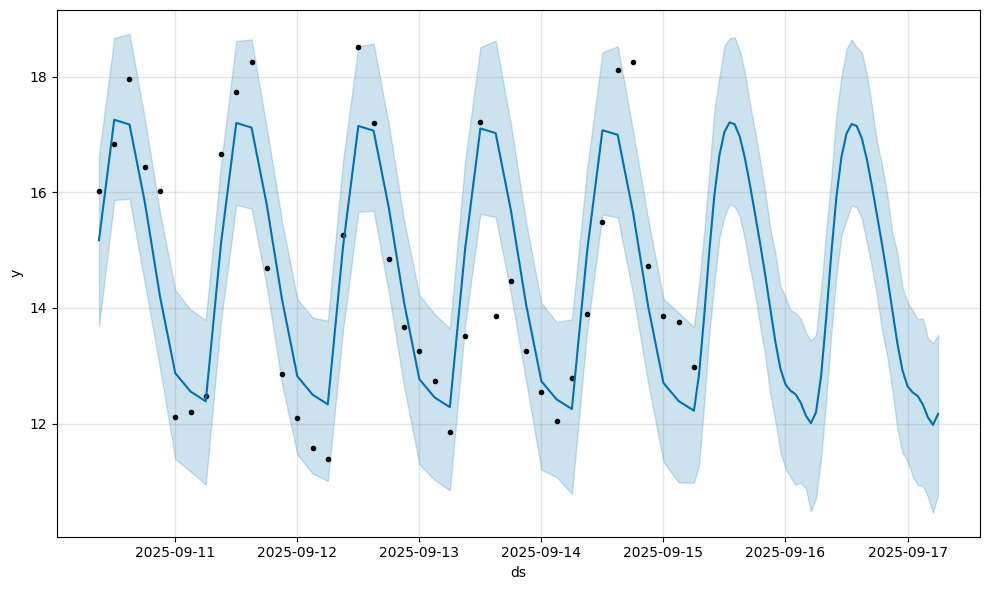

In [ ]:
from prophet import Prophet

prophet_df = df[['datetime', 'temp']].rename(columns={'datetime':'ds', 'temp':'y'})
model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=48, freq='H')
forecast = model.predict(future)

model.plot(forecast)
plt.show()


# Deep learning forecasting

LSTM Weather Forecasting Workflow:
1. Preprocess data:
   - Select features (temp, humidity, etc.)
   - Scale values to [0,1] for neural network stability

2. Create sequences:
   - Use last SEQ_LEN (5) timesteps as input
   - Predict next temperature value

3. Build & train LSTM model:
   - Stacked LSTM layers with dropout (prevent overfitting)
   - Optimizer: Adam, Loss: MSE
   - Train on 70% data, validate on 30%

4. Predict & evaluate:
   - Model forecasts future temps from test data
   - Inverse-scale predictions back to original range
   - Plot actual vs predicted temperatures


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 474ms/step - loss: 0.2311 - val_loss: 0.1074
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1318 - val_loss: 0.0700
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0946 - val_loss: 0.1098
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1007 - val_loss: 0.1517
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.1024 - val_loss: 0.1280
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0950 - val_loss: 0.0891
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0885 - val_loss: 0.0670
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0658 - val_loss: 0.0568
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0791 - val_loss: 0.0529
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0825 - val_loss: 0.0506
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0642 - val_loss: 0.0515
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0532 - val_loss: 0.06

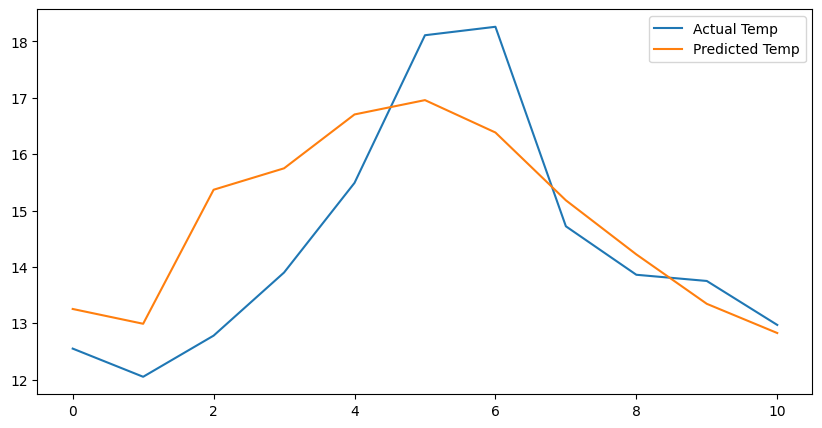

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ---------------------------
# 1. Load your weather data
# ---------------------------
# Keep relevant features
features = ['temp', 'humidity', 'pressure', 'wind_speed']
data = df[features].values

# Scale features to [0,1]
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ---------------------------
# 2. Create sequences
# ---------------------------
def create_sequences(data, seq_len=5):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])       # past seq_len steps
        y.append(data[i+seq_len, 0])      # predict "temp" next step
    return np.array(X), np.array(y)

SEQ_LEN = 5
X, y = create_sequences(data_scaled, SEQ_LEN)

# Train/test split
split = int(len(X)*0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------------
# 3. Build LSTM model
# ---------------------------
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# ---------------------------
# 4. Predictions
# ---------------------------
y_pred = model.predict(X_test)

# Inverse scale for plotting
# Only inverse the temp column
temp_scaler = MinMaxScaler()
temp_scaler.min_, temp_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_test_inv = (y_test - scaler.min_[0]) / scaler.scale_[0]
y_pred_inv = (y_pred.flatten() - scaler.min_[0]) / scaler.scale_[0]

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Actual Temp")
plt.plot(y_pred_inv, label="Predicted Temp")
plt.legend()
plt.show()
